In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [70]:
#Choose a date
def Choose_date(): 
    first_date = dt.datetime.strptime(session.query(Measurement.date).first()[0], '%Y-%m-%d')
    dates = np.ravel(session.query(Measurement.date).all())
    y=1
    while(y==1):
        date = np.random.choice(dates)
        if dt.datetime.strptime(date, '%Y-%m-%d') > (first_date - dt.timedelta(days=365)):
            y=0
            return dt.datetime.strptime(date, '%Y-%m-%d')

In [71]:
# Design a query to retrieve the last 12 months of precipitation data from the date chosen and plot the results
# Calculate the date 1 year ago from the date chosen

last_date = Choose_date()
date_year_ago =  last_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement.date, func.sum(Measurement.prcp)). \
    filter(Measurement.date <= last_date, Measurement.date > date_year_ago). \
    group_by(Measurement.date).order_by(Measurement.date).all()   

# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Total Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df.head()
# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


,Total Precipitation
Date,
2011-07-14,0.40
2011-07-15,0.75
2011-07-16,0.37
2011-07-17,1.10
2011-07-18,0.26


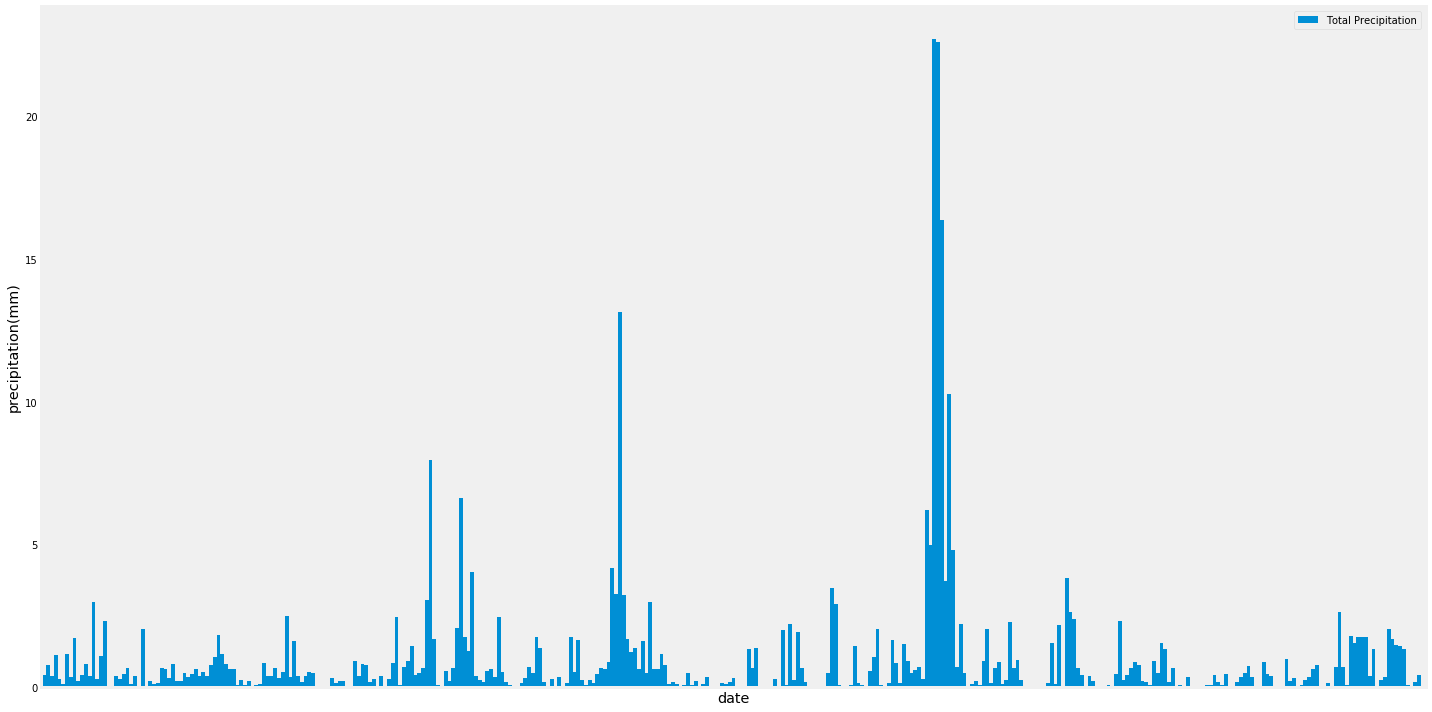

In [72]:
precipitation_df.plot.bar(figsize = (20,10), width = 1)
plt.xlabel('date', fontsize='x-large')
plt.ylabel('precipitation(mm)', fontsize='x-large')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tight_layout()
plt.grid(False)
plt.show()

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Total Precipitation
count,365.000000
mean,0.921370
std,2.234011
min,0.000000
25%,0.070000
50%,0.370000
75%,0.840000
max,22.730000


In [74]:
# How many stations are available in this dataset?
stations_count = session.query(Station.station).group_by(Station.station).count()

In [75]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.date)). \
    group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [76]:
most_active_station = active_stations[0][0]
station_name = session.query(Station.name).filter(Station.station == most_active_station).one()[0]
print(f"Most active station: {most_active_station} - {station_name}")

Most active station: USC00519281 - WAIHEE 837.5, HI US


In [77]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of most active station?
temp_sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active_station_details = session.query(*temp_sel).filter(Measurement.station == most_active_station).all()
most_active_station_details

[(54.0, 85.0, 71.66378066378067)]

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp_date = session.query(Measurement.tobs). \
    filter(Measurement.station == most_active_station). \
    filter(Measurement.date <= last_date,Measurement.date > date_year_ago).all()
temp_df = pd.DataFrame(temp_date, columns=['Temperature'])
temp_df.head()

,Temperature
0,72.0
1,72.0
2,75.0
3,77.0
4,73.0


In [79]:
# Divide the temperature into bin
t_min = temp_df["Temperature"].min().round()
t_max = temp_df["Temperature"].max().round()
t_bin = ((t_max-t_min)/12)
temp_bin = np.arange(t_min, t_max + t_bin, t_bin).round(1)

bin_name = []
for i in range(len(temp_bin)-1):
    bin_name.append(f"{temp_bin[i]} - {temp_bin[i+1]}")   
temp_df["Range"]= pd.cut(temp_df["Temperature"], temp_bin, labels=bin_name)
temp_df.head()

,Temperature,Range
0,72.0,70.5 - 72.2
1,72.0,70.5 - 72.2
2,75.0,74.0 - 75.8
3,77.0,75.8 - 77.5
4,73.0,72.2 - 74.0


In [80]:
count = temp_df["Range"].value_counts()
temp_plot = pd.DataFrame({"Frequency": count})
temp_plot.sort_index(inplace=True)
temp_plot.head()

,Frequency
60.0 - 61.8,3
61.8 - 63.5,7
63.5 - 65.2,9
65.2 - 67.0,25
67.0 - 68.8,21


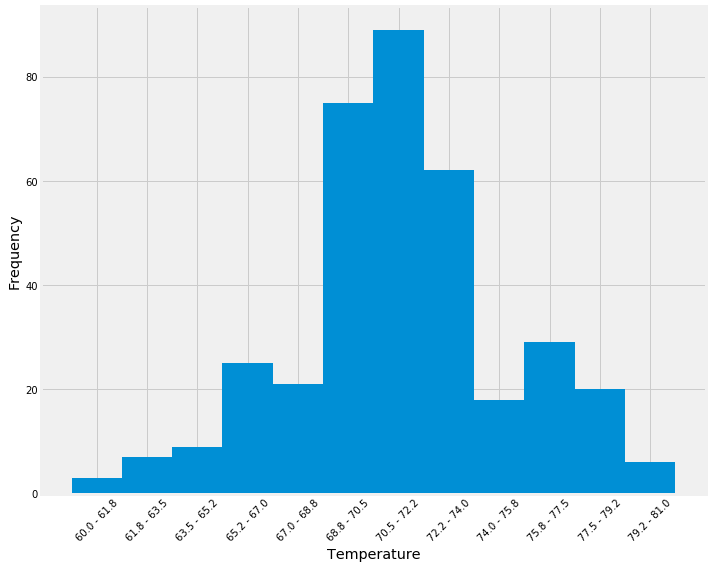

In [81]:
# plot the results as a histogram

fig, ax = plt.subplots(figsize=(10,8))
rectsPass = ax.bar(temp_plot.index, temp_plot["Frequency"], width=1)

#plt.bar(temp_plot.index(), temp_plot["Frequency"])
plt.xlabel('Temperature', fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.xticks(rotation="45")
plt.tight_layout()
plt.grid(True)
plt.show()

In [68]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
#print(calc_temps('2012-02-28', '2012-03-05'))

In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
month_names = []
year_month = []

for value in temp_df['Date']:
    date = dt.datetime.strptime(value, "%Y-%m-%d")
    year_month.append(str(date.year) + "-" + str(date.month))
    month_name = dt.datetime.strptime(value,'%Y-%m-%d').strftime('%B')
    if month_name not in month_names:
        month_names.append(month_name)
temp_df["Month"] = year_month
temp_df.head()